In [2]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 1.7 MB/s 


In [41]:
import pandas as pd
import re
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import itertools
import nltk
from collections import Counter
from plotly import tools
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from collections import defaultdict
from wordcloud import STOPWORDS, WordCloud
import string
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model
from keras.callbacks import EarlyStopping

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pd.set_option('display.max_colwidth', -1)
path = "/content/drive/MyDrive/MIT FutureMakers/Day 18/Sarcasm_Headlines_Dataset_v2.json"
sar_acc = pd.read_json(path,lines=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [6]:
sar_acc['source'] = sar_acc['article_link'].apply(lambda x: re.findall(r'\w+', x)[2])

In [7]:
sar_acc.head()

,is_sarcastic,headline,article_link,source
0,1,thirtysomething scientists unveil doomsday clock of hair loss,https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205,theonion
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html,huffingtonpost
3,1,inclement weather prevents liar from getting to work,https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031,theonion
4,1,mother comes pretty close to using word 'streaming' correctly,https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546,theonion


In [8]:
sar_acc_tar = sar_acc['is_sarcastic'].value_counts()
labels = ['Acclaim', 'Sarcastic']
sizes = (np.array((sar_acc_tar / sar_acc_tar.sum())*100))
colors = ['#58D68D', '#9B59B6']

In [9]:
trace = go.Pie(labels=labels, values=sizes, opacity = 0.8, hoverinfo='label+percent', marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))
layout = go.Layout(title='Sarcastic Vs Acclaim')
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="Sa_Ac")

In [10]:
all_words = sar_acc['headline'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
       )]

In [11]:
layout = go.Layout(
    title='Frequent Occuring word (unclean) in Headlines'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')

In [12]:
sar_det = sar_acc[sar_acc.is_sarcastic==1]
sar_det.reset_index(drop=True, inplace=True)
acc_det = sar_acc[sar_acc.is_sarcastic==0]
acc_det.reset_index(drop=True, inplace=True)

In [13]:
sar_news = []
for rows in range(0, sar_det.shape[0]):
    head_txt = sar_det.headline[rows]
    head_txt = head_txt.split(" ")
    sar_news.append(head_txt)

In [14]:
sar_list = list(itertools.chain(*sar_news))

In [15]:
acc_news = []
for rows in range(0, acc_det.shape[0]):
    head_txt = acc_det.headline[rows]
    head_txt = head_txt.split(" ")
    acc_news.append(head_txt)

In [16]:
acc_list = list(itertools.chain(*acc_news))

In [32]:
#download stopwords and wordnet here
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet
      Unzipping corpora/wordnet.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [18]:
stopwords = nltk.corpus.stopwords.words('english')
sar_list_restp = [word for word in sar_list if word.lower() not in stopwords]
acc_list_restp = [word for word in acc_list if word.lower() not in stopwords]

In [19]:
print("Length of original Sarcasm list: {0} words\n"
      "Length of Sarcasm list after stopwords removal: {1} words"
      .format(len(sar_list), len(sar_list_restp)))


Length of original Sarcasm list: 140546 words
Length of Sarcasm list after stopwords removal: 105627 words


In [20]:
print("Length of original Acclaim list: {0} words\n"
      "Length of Acclaim list after stopwords removal: {1} words"
      .format(len(acc_list), len(acc_list_restp)))

Length of original Acclaim list: 147128 words
Length of Acclaim list after stopwords removal: 103525 words


In [21]:
sar_cnt = Counter(sar_list_restp)
acc_cnt = Counter(acc_list_restp)

In [22]:
sar_cnt_df = pd.DataFrame(list(sar_cnt.items()), columns = ['Words', 'Freq'])
sar_cnt_df = sar_cnt_df.sort_values(by=['Freq'], ascending=False)
acc_cnt_df = pd.DataFrame(list(acc_cnt.items()), columns = ['Words', 'Freq'])
acc_cnt_df = acc_cnt_df.sort_values(by=['Freq'], ascending=False)

In [23]:
sar_cnt_df_30 = sar_cnt_df.head(30)
acc_cnt_df_30 = acc_cnt_df.head(30)

In [24]:
sar_tr  = go.Bar(
    x=sar_cnt_df_30['Freq'],
    y=sar_cnt_df_30['Words'],
    name='Sarcasm',
    marker=dict(
        color='rgba(155, 89, 182, 0.6)',
        line=dict(
            color='rgba(155, 89, 182, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)

In [25]:
acc_tr  = go.Bar(
    x=acc_cnt_df_30['Freq'],
    y=acc_cnt_df_30['Words'],
    name='Acclaim',
    marker=dict(
        color='rgba(88, 214, 141, 0.6)',
        line=dict(
            color='rgba(88, 214, 141, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)


In [26]:
fig = tools.make_subplots(rows=2, cols=1, subplot_titles=('Top 30 Most occuring words in Sarcasm Headlines',
                                                          'Top 30 Most occuring words in Acclaim Headlines'))

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [27]:
fig.append_trace(sar_tr, 1, 1)
fig.append_trace(acc_tr, 2, 1)

In [28]:
fig['layout'].update(height=1200, width=800)

Layout({
    'annotations': [{'font': {'size': 16},
                     'showarrow': False,
                     'text': 'Top 30 Most occuring words in Sarcasm Headlines',
                     'x': 0.5,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': 'Top 30 Most occuring words in Acclaim Headlines',
                     'x': 0.5,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 0.375,
                     'yanchor': 'bottom',
                     'yref': 'paper'}],
    'height': 1200,
    'template': '...',
    'width': 800,
    'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0]},
    'xaxis2': {'anchor': 'y2', 'domain': [0.0, 1.0]},
    'yaxis': {'anchor': 'x', 'domain': [0.625, 

In [29]:
iplot(fig, filename='sar_vs_acc')

In [30]:
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)

print("The stemmed form of learning is: {}".format(stemmer.stem("learning")))
print("The stemmed form of learns is: {}".format(stemmer.stem("learns")))
print("The stemmed form of learn is: {}".format(stemmer.stem("learn")))
print("=="*46)
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))
print("=="*46)

The stemmed form of learning is: learn
The stemmed form of learns is: learn
The stemmed form of learn is: learn
The stemmed form of leaves is: leav


In [33]:
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


In [35]:
sar_wost_lem = []
for batch in sar_news:
    sar_list_restp = [word for word in batch if word.lower() not in stopwords]
    lemm = WordNetLemmatizer()
    sar_list_lemm =  [lemm.lemmatize(word) for word in sar_list_restp]
    sar_wost_lem.append(sar_list_lemm)


In [36]:
acc_wost_lem = []
for batch in acc_news:
    acc_list_restp = [word for word in batch if word.lower() not in stopwords]
    lemm = WordNetLemmatizer()
    acc_list_lemm =  [lemm.lemmatize(word) for word in acc_list_restp]
    acc_wost_lem.append(sar_list_lemm)

In [37]:
vec = []
for block in sar_wost_lem:
    vectorizer = CountVectorizer(min_df=0)
    sentence_transform = vectorizer.fit_transform(block)
    vec.append(sentence_transform)
    
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['clarifies', 'dad', 'food', 'stop']

The vectorized array looks like:
 [[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [38]:
%matplotlib inline

In [39]:
sar_list_wd = list(itertools.chain(*sar_wost_lem))

In [44]:
sar_wost_lem_df = pd.DataFrame({'sarcasm':sar_wost_lem})
acc_wost_lem_df = pd.DataFrame({'acclaim':acc_wost_lem})

In [45]:
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


In [46]:
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [47]:
freq_dict = defaultdict(int)
for sent in sar_wost_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sar_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


In [48]:
freq_dict = defaultdict(int)
for sent in acc_wost_lem_df["acclaim"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
acc_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')


In [49]:
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of Sarcasm Headlines", 
                                          "Frequent bigrams of Acclaim Headlines"])
fig.append_trace(sar_2, 1, 1)
fig.append_trace(acc_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots Sarcasm Vs Acclaim after removing Stopwords")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [50]:
freq_dict = defaultdict(int)
for sent in sar_wost_lem_df["sarcasm"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sar_2 = horizontal_bar_chart(fd_sorted.head(50), '#9B59B6')


In [51]:
freq_dict = defaultdict(int)
for sent in acc_wost_lem_df["acclaim"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
acc_2 = horizontal_bar_chart(fd_sorted.head(50), '#58D68D')


In [52]:
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent Trigrams of Sarcasm Headlines", 
                                          "Frequent Trigrams of Acclaim Headlines"])
fig.append_trace(sar_2, 1, 1)
fig.append_trace(acc_2, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Trigram Plots Sarcasm Vs Acclaim after removing Stopwords")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [53]:
sar_acc["num_words"] = sar_acc["headline"].apply(lambda x: len(str(x).split()))


In [54]:
sar_acc["num_unique_words"] = sar_acc["headline"].apply(lambda x: len(set(str(x).split())))

In [55]:
sar_acc["num_chars"] = sar_acc["headline"].apply(lambda x: len(str(x)))


In [56]:
sar_acc["num_stopwords"] = sar_acc["headline"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


In [57]:
sar_acc["num_punctuations"] =sar_acc['headline'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

In [58]:
sar_acc["num_words_upper"] = sar_acc["headline"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [59]:
sar_acc["num_words_title"] = sar_acc["headline"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [60]:
sar_acc["mean_word_len"] = sar_acc["headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A v

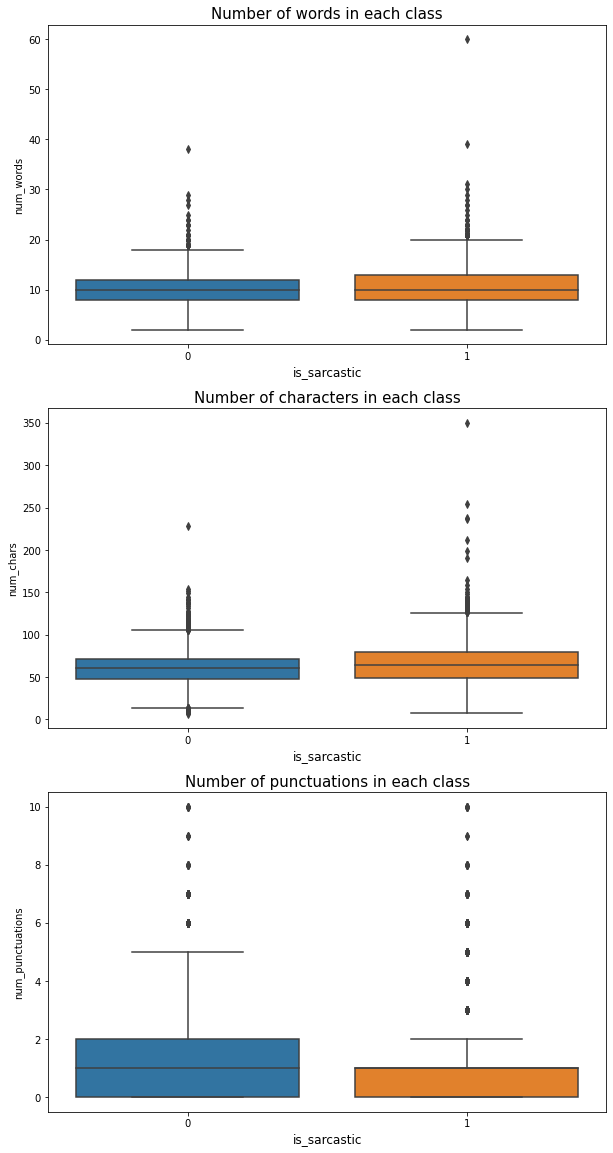

In [61]:
color = sns.color_palette()

sar_acc['num_words'].loc[sar_acc['num_words']>60] = 60

sar_acc['num_punctuations'].loc[sar_acc['num_punctuations']>10] = 10

sar_acc['num_chars'].loc[sar_acc['num_chars']>350] = 350

sar_acc['num_words'].loc[sar_acc['num_words']>60] = 60

sar_acc['num_punctuations'].loc[sar_acc['num_punctuations']>10] = 10

sar_acc['num_chars'].loc[sar_acc['num_chars']>350] = 350

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='is_sarcastic', y='num_words', data=sar_acc, ax=axes[0])
axes[0].set_xlabel('is_sarcastic', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_chars', data=sar_acc, ax=axes[1])
axes[1].set_xlabel('is_sarcastic', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_punctuations', data=sar_acc, ax=axes[2])
axes[2].set_xlabel('is_sarcastic', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [62]:
X = sar_acc.headline
Y = sar_acc.is_sarcastic
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [63]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [64]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [65]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [66]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [67]:
model.fit(sequences_matrix,Y_train,batch_size=100,epochs=5,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/5
207/207 [==============================] - 56s 171ms/step - loss: 0.6681 - accuracy: 0.6976 - val_loss: 0.5051 - val_accuracy: 0.7524


In [68]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [69]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

179/179 [==============================] - 4s 23ms/step - loss: 0.5165 - accuracy: 0.7524
Test set
  Loss: 0.517
  Accuracy: 0.752
